## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn7-3 copy 2.ipynb에서 ddqn적용

* reward -= distance / 4.8 * 2로 디자인하니 처음에 너무 치우쳐져 생성된 경우에 바로 pole을 쓰러트려 음수 보상을 받는 것을 피하는 전략이 나왔음
* reward -= distance / 4.8으로 디자인해야겠다

In [1]:
import gymnasium
from gymnasium.envs.registration import register
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [3]:
register(
    id='CartPole-v2',
    entry_point='cartpole_v2:CartPoleEnv',
    max_episode_steps=500,
)
env = gymnasium.make('CartPole-v2')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q)

In [4]:
lr = 0.0001
discount = 0.99
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [5]:
scores = []
action_count = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_actions = q(batch.next_state[~batch.terminated]).max(1).indices
            next_state_values[~batch.terminated] = target_q(batch.next_state[~batch.terminated]).gather(1, next_state_actions.unsqueeze(1)).squeeze()
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict()
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    scores.append(score)

    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]))

  0%|          | 0/600 [00:00<?, ?it/s]

 17%|█▋        | 100/600 [00:16<01:41,  4.91it/s]

23.748416963639325


 33%|███▎      | 200/600 [01:15<07:42,  1.16s/it]

75.1619955109497


 50%|█████     | 300/600 [04:41<16:00,  3.20s/it]

292.8088602782247


 67%|██████▋   | 400/600 [10:21<10:56,  3.28s/it]

468.0223301553092


 83%|████████▎ | 500/600 [16:00<05:44,  3.45s/it]

488.7004316645173


100%|██████████| 600/600 [21:49<00:00,  2.18s/it]

493.4810519737807


In [6]:
len(replay_buffer)

10000

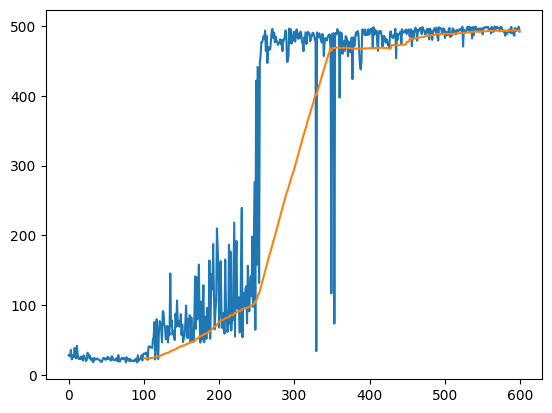

In [7]:
import matplotlib.pyplot as plt
plt.plot(scores)
smooth_size = 100
scores_smooth = []
scores_sum = sum(scores[:smooth_size])
for i in range(len(scores) - smooth_size):
    scores_sum += scores[i + smooth_size] - scores[i]
    scores_smooth.append(scores_sum / smooth_size)
plt.plot(range(smooth_size, len(scores)), scores_smooth)

In [8]:
env = gymnasium.make('CartPole-v2', render_mode='human')
valid_scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8
        score += reward
        state = next_state
        if terminated or truncated:
            break
    valid_scores.append(score)
env.close()
valid_scores

[491.632673992588,
 495.29003240800023,
 492.0816541727009,
 493.84793127227266,
 499.66833072769685,
 491.9993380596866,
 492.5642170927798,
 489.610705873458,
 487.6586946723491,
 497.0883851344785]

In [9]:
env.close()

In [10]:
env = gymnasium.make('CartPole-v1')

/home/seokj/workspace/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v1 is out of date. You should consider upgrading to version `v2`.
  logger.warn(
